# Índice de Similitud Estructural entre Imágenes

Este notebook demuestra el cálculo de índices de similitud estructural entre imágenes:
- **SSIM (Structural Similarity Index)**: Mide similitud estructural (0-1, donde 1 es idéntico)
- **MSE (Mean Squared Error)**: Error cuadrático medio (menor es mejor)

Compararemos (todos del mismo video):
1. **Dos imágenes similares**: Frames consecutivos del mismo video con 0.9 <= SSIM < 0.98
2. **Dos imágenes diferentes**: Frames del mismo video pero con mayor separación temporal y SSIM < 0.9


In [63]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.stats import pearsonr
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configurar rutas
notebook_dir = Path.cwd()
frames_dir = notebook_dir / "frames"

print(f"Directorio de trabajo: {notebook_dir}")
print(f"Directorio de frames: {frames_dir}")


Directorio de trabajo: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks
Directorio de frames: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/frames


In [64]:
def load_image(image_path):
    """Carga una imagen y la convierte a RGB."""
    img = cv2.imread(str(image_path))
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def calculate_mse(img1, img2):
    """Calcula el Error Cuadrático Medio (MSE)."""
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)
    return mse

def calculate_psnr(img1, img2):
    """Calcula el Peak Signal-to-Noise Ratio (PSNR)."""
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    try:
        psnr_value = psnr(img1, img2, data_range=255)
        return psnr_value
    except:
        return 0.0

def calculate_ssim_score(img1, img2):
    """Calcula el Structural Similarity Index (SSIM)."""
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    # Convertir a escala de grises para SSIM
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        gray1, gray2 = img1, img2
    
    try:
        ssim_value = ssim(gray1, gray2, data_range=255)
        return ssim_value
    except:
        return 0.0

def calculate_correlation(img1, img2):
    """Calcula la correlación de Pearson entre los píxeles."""
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    # Aplanar las imágenes
    flat1 = img1.flatten().astype(float)
    flat2 = img2.flatten().astype(float)
    
    try:
        corr, _ = pearsonr(flat1, flat2)
        return corr if not np.isnan(corr) else 0.0
    except:
        return 0.0

def calculate_histogram_similarity(img1, img2):
    """Calcula la similitud de histogramas usando correlación."""
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    # Calcular histogramas para cada canal
    hist1 = []
    hist2 = []
    
    for i in range(3):  # RGB
        h1 = cv2.calcHist([img1], [i], None, [256], [0, 256])
        h2 = cv2.calcHist([img2], [i], None, [256], [0, 256])
        hist1.append(h1.flatten())
        hist2.append(h2.flatten())
    
    # Calcular correlación promedio
    correlations = []
    for h1, h2 in zip(hist1, hist2):
        try:
            corr, _ = pearsonr(h1, h2)
            correlations.append(corr if not np.isnan(corr) else 0.0)
        except:
            correlations.append(0.0)
    
    return np.mean(correlations)

def calculate_all_metrics(img1, img2):
    """Calcula los índices de similitud (SSIM y MSE)."""
    metrics = {
        'SSIM': calculate_ssim_score(img1, img2),
        'MSE': calculate_mse(img1, img2)
    }
    return metrics


In [65]:
# Buscar caso especial: MSE similar pero SSIM diferente
print("\n🔍 Buscando caso especial: MSE similar pero SSIM diferente...")
print("   (Esto demuestra que MSE y SSIM miden aspectos diferentes)")

case_found = False
img_case_1_path = None
img_case_2_path = None
img_case_3_path = None
img_case_4_path = None
best_case_score = 0.0

# Buscar en los primeros 1000 frames
search_limit_case = min(1000, len(frames_video1) - 200)

for i in tqdm(range(search_limit_case), desc="Buscando caso especial", ncols=80):
    if case_found:
        break
    
    # Cargar frame base
    frame_base = load_image(frames_video1[i])
    if frame_base is None:
        continue
    
    # Comparar con varios frames adelante
    for j in range(i + 10, min(i + 200, len(frames_video1)), 10):
        frame_comp1 = load_image(frames_video1[j])
        if frame_comp1 is None:
            continue
        
        # Calcular métricas para par 1
        mse1 = calculate_mse(frame_base, frame_comp1)
        ssim1 = calculate_ssim_score(frame_base, frame_comp1)
        
        # Buscar otro par con MSE similar pero SSIM diferente
        for k in range(j + 10, min(j + 200, len(frames_video1)), 10):
            frame_comp2 = load_image(frames_video1[k])
            if frame_comp2 is None:
                continue
            
            # Calcular métricas para par 2
            mse2 = calculate_mse(frame_base, frame_comp2)
            ssim2 = calculate_ssim_score(frame_base, frame_comp2)
            
            # Verificar si MSE es similar pero SSIM es diferente
            mse_diff = abs(mse1 - mse2) / max(mse1, mse2) if max(mse1, mse2) > 0 else 1.0
            ssim_diff = abs(ssim1 - ssim2)
            
            # Criterio: MSE similar (diferencia < 20%) pero SSIM diferente (diferencia > 0.2)
            if mse_diff < 0.2 and ssim_diff > 0.2:
                # Calcular score: cuanto mayor diferencia de SSIM con MSE similar, mejor
                case_score = ssim_diff / (mse_diff + 0.01)
                
                if case_score > best_case_score:
                    best_case_score = case_score
                    img_case_1_path = frames_video1[i]  # Frame base
                    img_case_2_path = frames_video1[j]  # Par 1
                    img_case_3_path = frames_video1[i]  # Frame base (mismo)
                    img_case_4_path = frames_video1[k]  # Par 2
                    
                    # Guardar métricas del caso
                    case_mse1 = mse1
                    case_mse2 = mse2
                    case_ssim1 = ssim1
                    case_ssim2 = ssim2
                    
                    print(f"\n  ✓ Caso encontrado!")
                    print(f"     Par 1: MSE={mse1:.2f}, SSIM={ssim1:.4f}")
                    print(f"     Par 2: MSE={mse2:.2f}, SSIM={ssim2:.4f}")
                    print(f"     Diferencia MSE: {mse_diff*100:.1f}%")
                    print(f"     Diferencia SSIM: {ssim_diff:.4f}")
                    
                    if ssim_diff > 0.3:  # Si encontramos uno muy bueno, podemos parar
                        case_found = True
                        break

if img_case_1_path is None:
    print("\n  ⚠ No se encontró un caso claro, pero continuaremos con la búsqueda normal")
    case_special_available = False
else:
    print(f"\n  ✅ Caso especial encontrado con score={best_case_score:.2f}")
    case_special_available = True



🔍 Buscando caso especial: MSE similar pero SSIM diferente...
   (Esto demuestra que MSE y SSIM miden aspectos diferentes)


Buscando caso especial:   1%|                | 7/1000 [02:07<5:07:49, 18.60s/it]


  ✓ Caso encontrado!
     Par 1: MSE=1778.34, SSIM=0.6758
     Par 2: MSE=2070.38, SSIM=0.2855
     Diferencia MSE: 14.1%
     Diferencia SSIM: 0.3903

  ✓ Caso encontrado!
     Par 1: MSE=1969.38, SSIM=0.6546
     Par 2: MSE=2070.38, SSIM=0.2855
     Diferencia MSE: 4.9%
     Diferencia SSIM: 0.3691


Buscando caso especial:   1%|▏               | 8/1000 [02:25<5:00:31, 18.18s/it]


  ✓ Caso encontrado!
     Par 1: MSE=2022.85, SSIM=0.6448
     Par 2: MSE=2070.38, SSIM=0.2855
     Diferencia MSE: 2.3%
     Diferencia SSIM: 0.3593

  ✅ Caso especial encontrado con score=10.90


In [66]:
# Buscar frames disponibles
video_dirs = [d for d in frames_dir.iterdir() if d.is_dir()]
print(f"Videos encontrados: {len(video_dirs)}")
for vd in video_dirs:
    print(f"  - {vd.name}")

# Seleccionar dos videos diferentes
if len(video_dirs) >= 2:
    video1_dir = video_dirs[0]
    video2_dir = video_dirs[1]
    
    # Obtener frames del primer video
    frames_video1 = sorted(list(video1_dir.glob("*.jpg")))
    frames_video2 = sorted(list(video2_dir.glob("*.jpg")))
    
    print(f"\nFrames en {video1_dir.name}: {len(frames_video1)}")
    print(f"Frames en {video2_dir.name}: {len(frames_video2)}")
    
    # Buscar frames similares con SSIM entre 0.9 y 0.98 (similares pero no idénticos)
    print("\n🔍 Buscando frames similares (0.9 <= SSIM < 0.98)...")
    from tqdm import tqdm
    
    img_similar_1_path = None
    img_similar_2_path = None
    best_ssim = 0.0
    ssim_min = 0.9
    ssim_max = 0.98  # Evitar imágenes casi idénticas (SSIM >= 0.98)
    
    # Buscar en los primeros 2000 frames para tener más opciones
    search_limit = min(2000, len(frames_video1) - 1)
    
    for i in tqdm(range(search_limit), desc="Buscando frames similares", ncols=80):
        frame1 = load_image(frames_video1[i])
        frame2 = load_image(frames_video1[i + 1])
        
        if frame1 is not None and frame2 is not None:
            ssim_score = calculate_ssim_score(frame1, frame2)
            
            # Buscar SSIM en el rango deseado (0.9 a 0.98, excluyendo 0.98)
            if ssim_min <= ssim_score < ssim_max and ssim_score > best_ssim:
                best_ssim = ssim_score
                img_similar_1_path = frames_video1[i]
                img_similar_2_path = frames_video1[i + 1]
                print(f"\n  ✓ Encontrado SSIM={ssim_score:.4f} en frames {i} y {i+1}")
    
    # Si no encontramos frames en el rango, buscar el mejor disponible pero < 0.98
    if img_similar_1_path is None or best_ssim < ssim_min:
        print(f"\n  ⚠ No se encontraron frames con {ssim_min} <= SSIM < {ssim_max}")
        print("  🔄 Buscando el mejor par disponible (SSIM < 0.98)...")
        best_ssim = 0.0
        search_limit_extended = min(5000, len(frames_video1) - 1)
        
        for i in tqdm(range(search_limit_extended), desc="Buscando mejor par", ncols=80):
            frame1 = load_image(frames_video1[i])
            frame2 = load_image(frames_video1[i + 1])
            
            if frame1 is not None and frame2 is not None:
                ssim_score = calculate_ssim_score(frame1, frame2)
                
                # Aceptar solo si está en el rango deseado y es mejor que el actual
                if ssim_min <= ssim_score < ssim_max and ssim_score > best_ssim:
                    best_ssim = ssim_score
                    img_similar_1_path = frames_video1[i]
                    img_similar_2_path = frames_video1[i + 1]
        
        if best_ssim > 0:
            print(f"\n  ✓ Mejor par encontrado con SSIM={best_ssim:.4f} (en rango {ssim_min}-{ssim_max})")
        else:
            print(f"\n  ⚠ No se encontraron frames adecuados en el rango")
    else:
        print(f"\n  ✅ Frames similares encontrados con SSIM={best_ssim:.4f} ({ssim_min} <= SSIM < {ssim_max})")
    
    # Imágenes diferentes: buscar frames del mismo video con SSIM < 0.9
    print("\n🔍 Buscando frames diferentes del mismo video (SSIM < 0.9)...")
    img_different_1_path = None
    img_different_2_path = None
    best_ssim_different = 1.0  # Queremos el menor SSIM posible (más diferentes)
    
    # Buscar frames del mismo video pero con mayor separación temporal
    if len(frames_video1) > 100:
        search_limit_different = min(500, len(frames_video1) - 100)
        # Buscar frames con separación de al menos 50 frames para asegurar diferencia
        min_separation = 50
        
        for i in tqdm(range(search_limit_different), desc="Buscando frames diferentes", ncols=80):
            # Comparar frame i con frame i+separación (frames más separados temporalmente)
            for separation in [min_separation, min_separation * 2, min_separation * 3]:
                idx2 = i + separation
                if idx2 >= len(frames_video1):
                    continue
                
                frame1 = load_image(frames_video1[i])
                frame2 = load_image(frames_video1[idx2])
                
                if frame1 is not None and frame2 is not None:
                    ssim_score = calculate_ssim_score(frame1, frame2)
                    
                    # Buscar frames con SSIM < 0.9 (diferentes)
                    if ssim_score < 0.9 and ssim_score < best_ssim_different:
                        best_ssim_different = ssim_score
                        img_different_1_path = frames_video1[i]
                        img_different_2_path = frames_video1[idx2]
                        # Si encontramos uno muy diferente, podemos parar
                        if ssim_score < 0.5:
                            break
                if best_ssim_different < 0.5:
                    break
        
        if img_different_1_path is None:
            # Si no encontramos, usar frames muy separados del mismo video
            print("  ⚠ No se encontraron frames con SSIM < 0.9, usando frames muy separados")
            # Tomar frame inicial y uno del final
            img_different_1_path = frames_video1[0]
            img_different_2_path = frames_video1[min(len(frames_video1) - 1, len(frames_video1) // 4)]
        else:
            print(f"\n  ✅ Frames diferentes encontrados con SSIM={best_ssim_different:.4f} (< 0.9)")
    else:
        # Si el video es muy corto, usar frames del inicio y del final
        print("  ⚠ Video muy corto, usando frames del inicio y final")
        img_different_1_path = frames_video1[0]
        img_different_2_path = frames_video1[-1]
    
    print(f"\n📊 Imágenes seleccionadas:")
    if img_similar_1_path:
        print(f"  Similares (SSIM={best_ssim:.4f}): {img_similar_1_path.name} vs {img_similar_2_path.name}")
    if img_different_1_path:
        if 'best_ssim_different' in locals() and best_ssim_different < 1.0:
            print(f"  Diferentes (SSIM={best_ssim_different:.4f}): {img_different_1_path.name} vs {img_different_2_path.name}")
        else:
            print(f"  Diferentes: {img_different_1_path.name} vs {img_different_2_path.name}")
else:
    print("No hay suficientes videos para comparación")


Videos encontrados: 3
  - Bitcoin hoy ｜ Esteban Perez Trader
  - ARENA ALFA 
  - Bolsas hoy ｜ Esteban Pérez Inversor

Frames en Bitcoin hoy ｜ Esteban Perez Trader: 353829
Frames en ARENA ALFA : 49848

🔍 Buscando frames similares (0.9 <= SSIM < 0.98)...


Buscando frames similares:   0%|               | 9/2000 [00:00<01:33, 21.37it/s]


  ✓ Encontrado SSIM=0.9508 en frames 5 y 6

  ✓ Encontrado SSIM=0.9587 en frames 6 y 7

  ✓ Encontrado SSIM=0.9643 en frames 7 y 8

  ✓ Encontrado SSIM=0.9711 en frames 9 y 10


Buscando frames similares:   1%|▏             | 24/2000 [00:01<01:34, 20.88it/s]


  ✓ Encontrado SSIM=0.9763 en frames 20 y 21

  ✓ Encontrado SSIM=0.9769 en frames 24 y 25


Buscando frames similares:   2%|▎             | 46/2000 [00:02<01:36, 20.24it/s]


  ✓ Encontrado SSIM=0.9771 en frames 43 y 44


Buscando frames similares:   3%|▍             | 58/2000 [00:02<01:31, 21.27it/s]


  ✓ Encontrado SSIM=0.9779 en frames 53 y 54


Buscando frames similares:   6%|▊            | 127/2000 [00:06<01:26, 21.72it/s]


  ✓ Encontrado SSIM=0.9781 en frames 122 y 123


Buscando frames similares:  16%|██           | 311/2000 [00:14<01:18, 21.50it/s]


  ✓ Encontrado SSIM=0.9786 en frames 306 y 307


Buscando frames similares:  33%|████▏        | 653/2000 [00:29<00:59, 22.69it/s]


  ✓ Encontrado SSIM=0.9795 en frames 649 y 650


Buscando frames similares:  81%|█████████▋  | 1622/2000 [01:12<00:16, 22.88it/s]


  ✓ Encontrado SSIM=0.9798 en frames 1619 y 1620

  ✓ Encontrado SSIM=0.9800 en frames 1622 y 1623


Buscando frames similares: 100%|████████████| 2000/2000 [01:30<00:00, 22.20it/s]



  ✅ Frames similares encontrados con SSIM=0.9800 (0.9 <= SSIM < 0.98)

🔍 Buscando frames diferentes del mismo video (SSIM < 0.9)...


Buscando frames diferentes: 100%|█████████████| 500/500 [00:22<00:00, 21.83it/s]


  ✅ Frames diferentes encontrados con SSIM=0.0100 (< 0.9)

📊 Imágenes seleccionadas:
  Similares (SSIM=0.9800): -7ju1t4k4oE_20230411_frame7080.jpg vs -7ju1t4k4oE_20230411_frame7140.jpg
  Diferentes (SSIM=0.0100): -16hgxHbT0I_20220922_frame0.jpg vs -16hgxHbT0I_20220922_frame12600.jpg


In [67]:
# Cargar imágenes
img_similar_1 = load_image(img_similar_1_path)
img_similar_2 = load_image(img_similar_2_path)
img_different_1 = load_image(img_different_1_path)
img_different_2 = load_image(img_different_2_path)

print(f"Imagen similar 1: {img_similar_1.shape if img_similar_1 is not None else 'Error'}")
print(f"Imagen similar 2: {img_similar_2.shape if img_similar_2 is not None else 'Error'}")
print(f"Imagen diferente 1: {img_different_1.shape if img_different_1 is not None else 'Error'}")
print(f"Imagen diferente 2: {img_different_2.shape if img_different_2 is not None else 'Error'}")


Imagen similar 1: (720, 1280, 3)
Imagen similar 2: (720, 1280, 3)
Imagen diferente 1: (720, 1280, 3)
Imagen diferente 2: (720, 1280, 3)


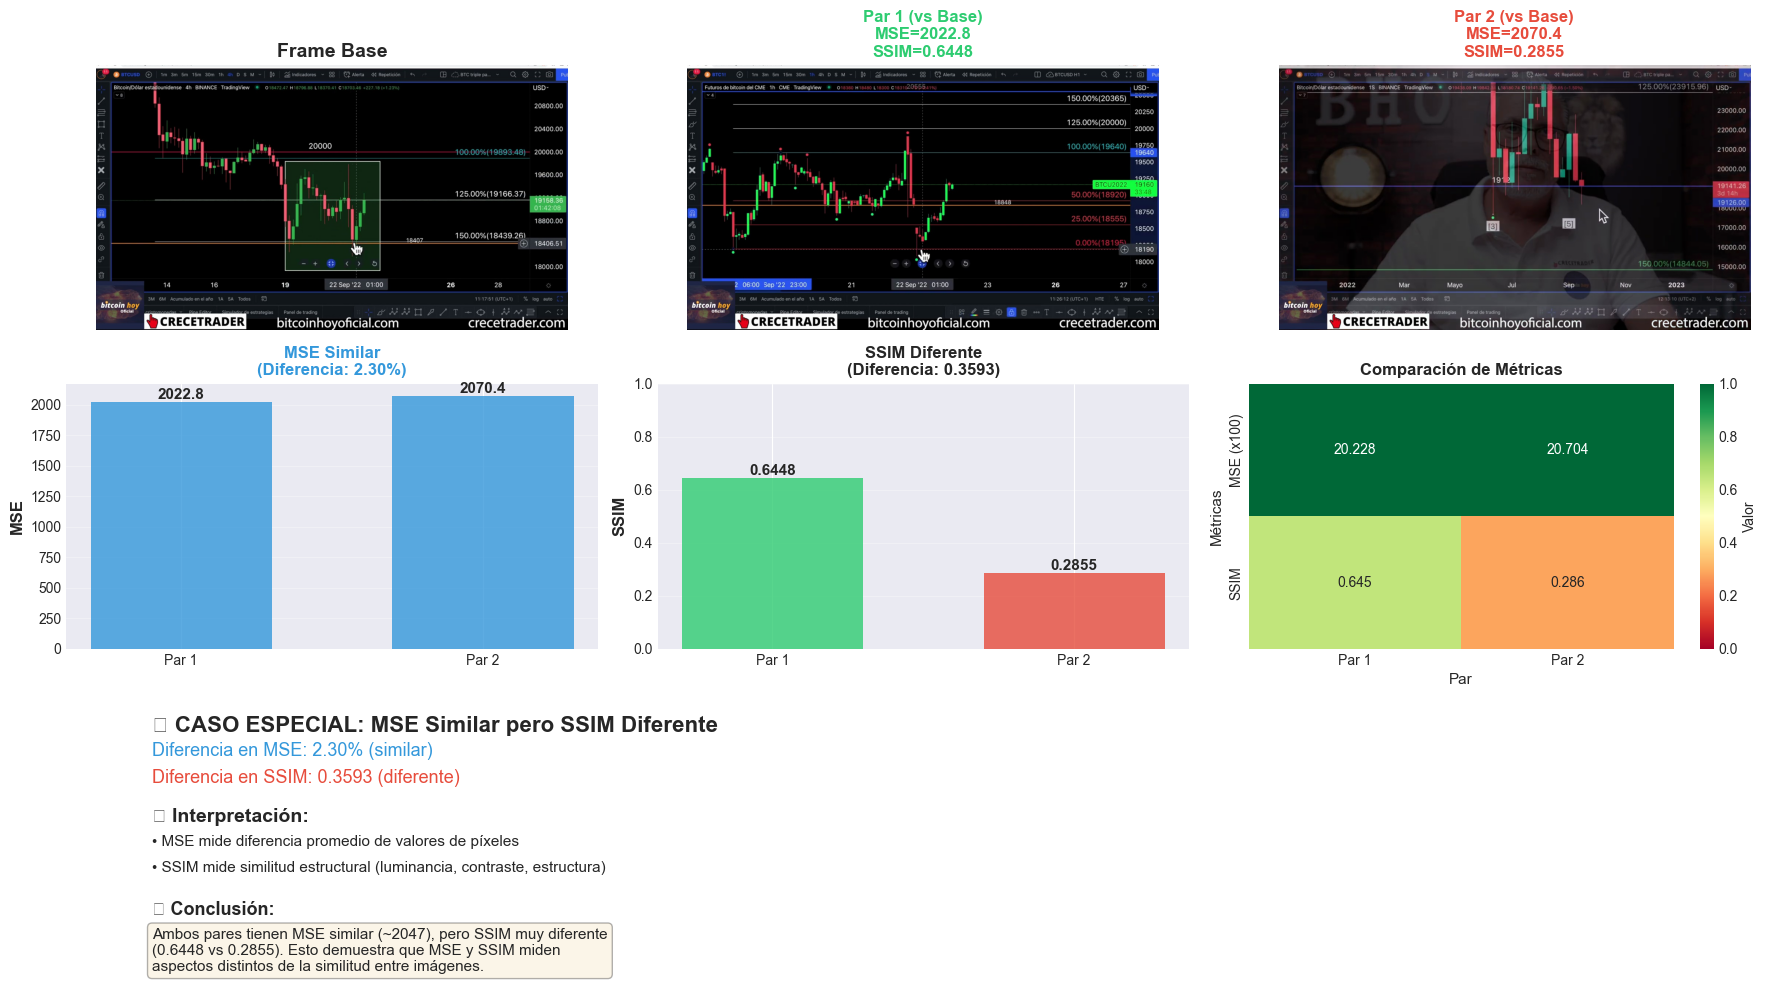


✅ Gráfico del caso especial guardado como 'caso_especial_mse_similar_ssim_diferente.png'


In [68]:
# Visualización del caso especial si está disponible
# Primero verificar si tenemos las imágenes del caso especial
if 'case_special_available' in locals() and case_special_available and img_case_1_path is not None:
    # Cargar imágenes del caso especial
    img_case_base = load_image(img_case_1_path)
    img_case_par1 = load_image(img_case_2_path)
    img_case_par2 = load_image(img_case_4_path)
    
    if img_case_base is not None and img_case_par1 is not None and img_case_par2 is not None:
        # Calcular métricas
        metrics_case_par1 = calculate_all_metrics(img_case_base, img_case_par1)
        metrics_case_par2 = calculate_all_metrics(img_case_base, img_case_par2)
        
        # Calcular diferencias
        mse_diff_pct = abs(metrics_case_par1['MSE'] - metrics_case_par2['MSE']) / max(metrics_case_par1['MSE'], metrics_case_par2['MSE']) * 100
        ssim_diff = abs(metrics_case_par1['SSIM'] - metrics_case_par2['SSIM'])
        
        # Crear visualización
        fig = plt.figure(figsize=(18, 10))
        
        # 1. Mostrar las 3 imágenes: Frame Base, Par 1, Par 2
        ax1 = plt.subplot(3, 3, 1)
        ax1.imshow(img_case_base)
        ax1.set_title('Frame Base', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        ax2 = plt.subplot(3, 3, 2)
        ax2.imshow(img_case_par1)
        mse1 = metrics_case_par1['MSE']
        ssim1 = metrics_case_par1['SSIM']
        ax2.set_title(f'Par 1 (vs Base)\nMSE={mse1:.1f}\nSSIM={ssim1:.4f}', 
                     fontsize=12, fontweight='bold', color='#2ecc71')
        ax2.axis('off')
        
        ax3 = plt.subplot(3, 3, 3)
        ax3.imshow(img_case_par2)
        mse2 = metrics_case_par2['MSE']
        ssim2 = metrics_case_par2['SSIM']
        ax3.set_title(f'Par 2 (vs Base)\nMSE={mse2:.1f}\nSSIM={ssim2:.4f}', 
                     fontsize=12, fontweight='bold', color='#e74c3c')
        ax3.axis('off')
        
        # 2. Gráfico de MSE - Mostrar que son similares
        ax4 = plt.subplot(3, 3, 4)
        mse_values = [metrics_case_par1['MSE'], metrics_case_par2['MSE']]
        colors_mse = ['#3498db', '#3498db']  # Mismo color porque son similares
        bars_mse = ax4.bar(['Par 1', 'Par 2'], mse_values, color=colors_mse, alpha=0.8, width=0.6)
        ax4.set_ylabel('MSE', fontsize=12, fontweight='bold')
        ax4.set_title(f'MSE Similar\n(Diferencia: {mse_diff_pct:.2f}%)', 
                     fontsize=12, fontweight='bold', color='#3498db')
        ax4.grid(True, alpha=0.3, axis='y')
        for bar in bars_mse:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # 3. Gráfico de SSIM - Mostrar que son diferentes
        ax5 = plt.subplot(3, 3, 5)
        ssim_values = [metrics_case_par1['SSIM'], metrics_case_par2['SSIM']]
        colors_ssim = ['#2ecc71', '#e74c3c']  # Colores diferentes porque SSIM es diferente
        bars_ssim = ax5.bar(['Par 1', 'Par 2'], ssim_values, color=colors_ssim, alpha=0.8, width=0.6)
        ax5.set_ylabel('SSIM', fontsize=12, fontweight='bold')
        ax5.set_title(f'SSIM Diferente\n(Diferencia: {ssim_diff:.4f})', 
                     fontsize=12, fontweight='bold')
        ax5.set_ylim(0, 1.0)
        ax5.grid(True, alpha=0.3, axis='y')
        for bar in bars_ssim:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # 4. Comparación lado a lado de métricas (Heatmap)
        ax6 = plt.subplot(3, 3, 6)
        comparison_data = {
            'MSE': [metrics_case_par1['MSE'] / 100, metrics_case_par2['MSE'] / 100],
            'SSIM': [metrics_case_par1['SSIM'], metrics_case_par2['SSIM']]
        }
        comparison_df = pd.DataFrame(comparison_data, index=['Par 1', 'Par 2'])
        comparison_df.columns = ['MSE (x100)', 'SSIM']
        sns.heatmap(comparison_df.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax6, 
                    cbar_kws={'label': 'Valor'}, vmin=0, vmax=1)
        ax6.set_title('Comparación de Métricas', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Métricas', fontsize=11)
        ax6.set_xlabel('Par', fontsize=11)
        
        # 5. Texto explicativo
        ax7 = plt.subplot(3, 3, (7, 9))
        ax7.text(0.05, 0.95, '💡 CASO ESPECIAL: MSE Similar pero SSIM Diferente', 
                ha='left', va='top', fontsize=16, fontweight='bold', transform=ax7.transAxes)
        ax7.text(0.05, 0.85, f'Diferencia en MSE: {mse_diff_pct:.2f}% (similar)', 
                ha='left', va='top', fontsize=13, transform=ax7.transAxes, color='#3498db')
        ax7.text(0.05, 0.75, f'Diferencia en SSIM: {ssim_diff:.4f} (diferente)', 
                ha='left', va='top', fontsize=13, transform=ax7.transAxes, color='#e74c3c')
        ax7.text(0.05, 0.60, '📊 Interpretación:', 
                ha='left', va='top', fontsize=14, fontweight='bold', transform=ax7.transAxes)
        ax7.text(0.05, 0.50, '• MSE mide diferencia promedio de valores de píxeles', 
                ha='left', va='top', fontsize=11, transform=ax7.transAxes)
        ax7.text(0.05, 0.40, '• SSIM mide similitud estructural (luminancia, contraste, estructura)', 
                ha='left', va='top', fontsize=11, transform=ax7.transAxes)
        ax7.text(0.05, 0.25, '✅ Conclusión:', 
                ha='left', va='top', fontsize=13, fontweight='bold', transform=ax7.transAxes)
        ax7.text(0.05, 0.15, 'Ambos pares tienen MSE similar (~{:.0f}), pero SSIM muy diferente\n({:.4f} vs {:.4f}). Esto demuestra que MSE y SSIM miden\naspectos distintos de la similitud entre imágenes.'.format(
                (mse1 + mse2) / 2, ssim1, ssim2), 
                ha='left', va='top', fontsize=11, transform=ax7.transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        ax7.axis('off')
        
        plt.tight_layout()
        plt.savefig('caso_especial_mse_similar_ssim_diferente.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✅ Gráfico del caso especial guardado como 'caso_especial_mse_similar_ssim_diferente.png'")
    else:
        print("\n⚠ No se pudieron cargar las imágenes del caso especial.")
elif 'case_special_images' in locals() and case_special_images is not None:
    # Usar las imágenes ya cargadas si están disponibles
    fig = plt.figure(figsize=(18, 10))
    # ... (código similar al anterior usando case_special_images)
    print("\n✅ Visualización del caso especial usando imágenes pre-cargadas")
else:
    print("\n⚠ Caso especial no encontrado. Ejecuta la celda 3 para buscar el caso especial.")


In [69]:
# Si se encontró el caso especial, calcular y mostrar sus métricas
if 'case_special_available' in locals() and case_special_available:
    print("\n" + "="*70)
    print("CASO ESPECIAL: MSE Similar pero SSIM Diferente")
    print("="*70)
    
    # Cargar imágenes del caso especial
    img_case_base = load_image(img_case_1_path)
    img_case_par1 = load_image(img_case_2_path)
    img_case_par2 = load_image(img_case_4_path)
    
    # Calcular métricas
    metrics_case_par1 = calculate_all_metrics(img_case_base, img_case_par1)
    metrics_case_par2 = calculate_all_metrics(img_case_base, img_case_par2)
    
    print(f"\nFrame Base: {img_case_1_path.name}")
    print(f"\nPar 1 (Frame Base vs {img_case_2_path.name}):")
    for metric, value in metrics_case_par1.items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\nPar 2 (Frame Base vs {img_case_4_path.name}):")
    for metric, value in metrics_case_par2.items():
        print(f"  {metric}: {value:.4f}")
    
    # Calcular diferencias
    mse_diff_pct = abs(metrics_case_par1['MSE'] - metrics_case_par2['MSE']) / max(metrics_case_par1['MSE'], metrics_case_par2['MSE']) * 100
    ssim_diff = abs(metrics_case_par1['SSIM'] - metrics_case_par2['SSIM'])
    
    print(f"\n📊 Análisis:")
    print(f"  Diferencia en MSE: {mse_diff_pct:.2f}% (similar)")
    print(f"  Diferencia en SSIM: {ssim_diff:.4f} (diferente)")
    print(f"\n💡 Interpretación:")
    print(f"  Ambos pares tienen MSE similar, pero SSIM muy diferente.")
    print(f"  Esto demuestra que MSE y SSIM miden aspectos distintos:")
    print(f"  - MSE: Diferencia promedio de valores de píxeles")
    print(f"  - SSIM: Similitud estructural (luminancia, contraste, estructura)")
    
    # Guardar para visualización
    case_special_images = {
        'base': img_case_base,
        'par1': img_case_par1,
        'par2': img_case_par2,
        'metrics_par1': metrics_case_par1,
        'metrics_par2': metrics_case_par2
    }
else:
    print("\n⚠ Caso especial no disponible, mostrando comparación estándar")
    case_special_images = None



CASO ESPECIAL: MSE Similar pero SSIM Diferente

Frame Base: -16hgxHbT0I_20220922_frame10320.jpg

Par 1 (Frame Base vs -16hgxHbT0I_20220922_frame20580.jpg):
  SSIM: 0.6448
  MSE: 2022.8492

Par 2 (Frame Base vs -16hgxHbT0I_20220922_frame2820.jpg):
  SSIM: 0.2855
  MSE: 2070.3804

📊 Análisis:
  Diferencia en MSE: 2.30% (similar)
  Diferencia en SSIM: 0.3593 (diferente)

💡 Interpretación:
  Ambos pares tienen MSE similar, pero SSIM muy diferente.
  Esto demuestra que MSE y SSIM miden aspectos distintos:
  - MSE: Diferencia promedio de valores de píxeles
  - SSIM: Similitud estructural (luminancia, contraste, estructura)


In [70]:
# Calcular métricas para imágenes similares
metrics_similar = calculate_all_metrics(img_similar_1, img_similar_2)

# Calcular métricas para imágenes diferentes
metrics_different = calculate_all_metrics(img_different_1, img_different_2)

print("=== MÉTRICAS PARA IMÁGENES SIMILARES ===")
for metric, value in metrics_similar.items():
    print(f"{metric}: {value:.4f}")

print("\n=== MÉTRICAS PARA IMÁGENES DIFERENTES ===")
for metric, value in metrics_different.items():
    print(f"{metric}: {value:.4f}")


=== MÉTRICAS PARA IMÁGENES SIMILARES ===
SSIM: 0.9800
MSE: 42.4308

=== MÉTRICAS PARA IMÁGENES DIFERENTES ===
SSIM: 0.0100
MSE: 44070.7579


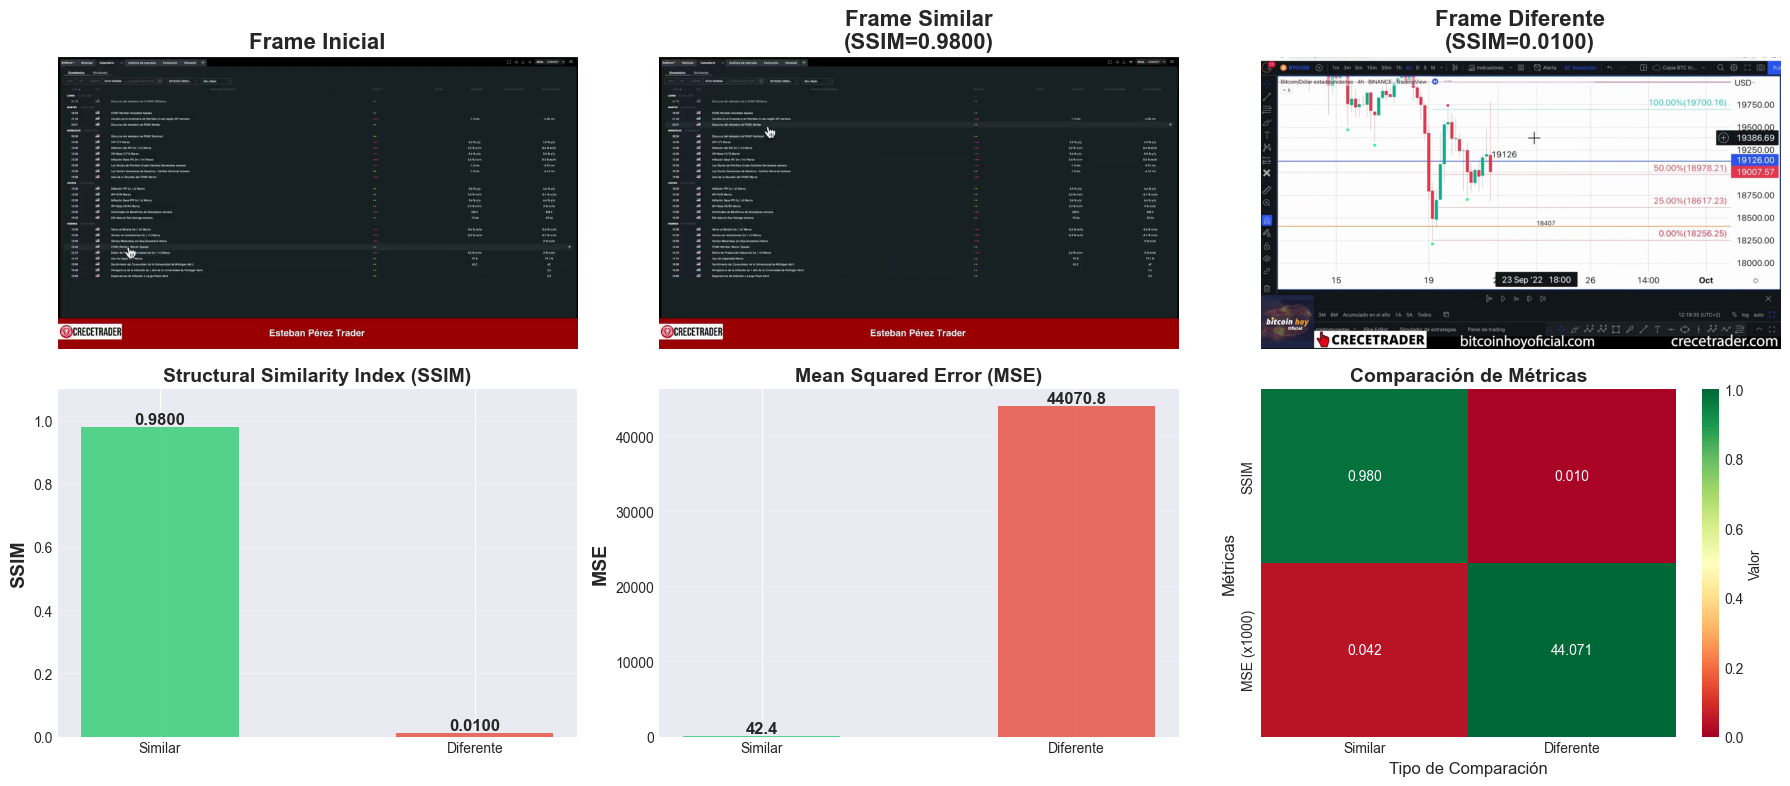


Gráfico guardado como 'indice_similitud_estructural_comparacion.png'


In [71]:
# Crear visualización comparativa - Solo 3 frames: primero, similar y diferente
fig = plt.figure(figsize=(18, 8))

# 1. Mostrar las 3 imágenes
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(img_similar_1)
ax1.set_title('Frame Inicial', fontsize=16, fontweight='bold')
ax1.axis('off')

ax2 = plt.subplot(2, 3, 2)
ax2.imshow(img_similar_2)
ssim_similar = metrics_similar['SSIM']
ax2.set_title(f'Frame Similar\n(SSIM={ssim_similar:.4f})', fontsize=16, fontweight='bold')
ax2.axis('off')

ax3 = plt.subplot(2, 3, 3)
ax3.imshow(img_different_2)
ssim_different = metrics_different['SSIM']
ax3.set_title(f'Frame Diferente\n(SSIM={ssim_different:.4f})', fontsize=16, fontweight='bold')
ax3.axis('off')

# 2. Gráfico de SSIM
ax4 = plt.subplot(2, 3, 4)
ssim_values = [metrics_similar['SSIM'], metrics_different['SSIM']]
colors_ssim = ['#2ecc71', '#e74c3c']
bars_ssim = ax4.bar(['Similar', 'Diferente'], ssim_values, color=colors_ssim, alpha=0.8, width=0.5)
ax4.set_ylabel('SSIM', fontsize=14, fontweight='bold')
ax4.set_title('Structural Similarity Index (SSIM)', fontsize=14, fontweight='bold')
ax4.set_ylim(0, 1.1)
ax4.grid(True, alpha=0.3, axis='y')
for bar in bars_ssim:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. Gráfico de MSE
ax5 = plt.subplot(2, 3, 5)
mse_values = [metrics_similar['MSE'], metrics_different['MSE']]
colors_mse = ['#2ecc71', '#e74c3c']
bars_mse = ax5.bar(['Similar', 'Diferente'], mse_values, color=colors_mse, alpha=0.8, width=0.5)
ax5.set_ylabel('MSE', fontsize=14, fontweight='bold')
ax5.set_title('Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
for bar in bars_mse:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. Comparación lado a lado de métricas
ax6 = plt.subplot(2, 3, 6)
comparison_data = {
    'SSIM': [metrics_similar['SSIM'], metrics_different['SSIM']],
    'MSE': [metrics_similar['MSE'] / 1000, metrics_different['MSE'] / 1000]  # Normalizar MSE para visualización
}
comparison_df = pd.DataFrame(comparison_data, index=['Similar', 'Diferente'])
comparison_df.columns = ['SSIM', 'MSE (x1000)']
sns.heatmap(comparison_df.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax6, 
            cbar_kws={'label': 'Valor'}, vmin=0, vmax=1)
ax6.set_title('Comparación de Métricas', fontsize=14, fontweight='bold')
ax6.set_ylabel('Métricas', fontsize=12)
ax6.set_xlabel('Tipo de Comparación', fontsize=12)

plt.tight_layout()
plt.savefig('indice_similitud_estructural_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado como 'indice_similitud_estructural_comparacion.png'")


In [72]:
# Crear tabla resumen
summary_data = {
    'Métrica': list(metrics_similar.keys()),
    'Imágenes Similares': list(metrics_similar.values()),
    'Imágenes Diferentes': list(metrics_different.values()),
    'Diferencia': [abs(s - d) for s, d in zip(metrics_similar.values(), metrics_different.values())]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Imágenes Similares'] = summary_df['Imágenes Similares'].round(4)
summary_df['Imágenes Diferentes'] = summary_df['Imágenes Diferentes'].round(4)
summary_df['Diferencia'] = summary_df['Diferencia'].round(4)

print("\n" + "="*70)
print("TABLA RESUMEN DE MÉTRICAS")
print("="*70)
print(summary_df.to_string(index=False))
print("\n" + "="*70)

# Guardar tabla
summary_df.to_csv('resumen_metricas_similitud.csv', index=False)
print("\nTabla guardada como 'resumen_metricas_similitud.csv'")



TABLA RESUMEN DE MÉTRICAS
Métrica  Imágenes Similares  Imágenes Diferentes  Diferencia
   SSIM              0.9800               0.0100      0.9700
    MSE             42.4308           44070.7579  44028.3271


Tabla guardada como 'resumen_metricas_similitud.csv'


## Interpretación de los Resultados

### Métricas para Imágenes Similares:
- **SSIM entre 0.9 y 0.98**: Las imágenes tienen estructura similar pero no idénticas
- **MSE bajo**: Poca diferencia en los valores de píxeles

### Métricas para Imágenes Diferentes:
- **SSIM < 0.9**: Estructura diferente, imágenes distintas
- **MSE alto**: Grandes diferencias en valores de píxeles

### Escalas de Interpretación:

**SSIM (Structural Similarity Index)**:
- 0.98 - 1.0: Imágenes casi idénticas (evitado en este ejemplo)
- 0.90 - 0.98: Imágenes similares (rango para imágenes similares)
- 0.50 - 0.90: Imágenes moderadamente diferentes
- 0.00 - 0.50: Imágenes muy diferentes (rango para imágenes diferentes)

**MSE (Mean Squared Error)**:
- 0 - 1000: Diferencias muy pequeñas
- 1000 - 5000: Diferencias pequeñas
- 5000 - 20000: Diferencias moderadas
- > 20000: Diferencias grandes

### Conclusión:
Los índices SSIM y MSE permiten cuantificar objetivamente qué tan similares o diferentes son dos imágenes, lo cual es útil para:
- Filtrado de frames duplicados
- Selección de keyframes
- Análisis de contenido visual
- Clasificación de imágenes
